In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df= pd.read_excel('dfwavgscores.xlsx')

In [2]:
demographic_info_columns = ['Country', 'ASBH02A', 'ASBH02B', 'ASBH03A', 'ASBH04', 'ASBH15A', 'ASBH15B', 'ASBH16', 'ASBH17A', 'ASBH17B', 'ASBH18AA', 'ASBH18AB', 'ASBG01', 'ASBG03','MINAGEARRIVAL', 'rounded_ages','ASDAGE','avgscore']

In [3]:
df_demo = df[demographic_info_columns]

## Removing missing values

I need to remove missing values for this stuff to actually be interesting. 

In [4]:
pivot_table_test = df_demo.pivot_table(
    index=['Country','ASBH02A'],
    aggfunc=lambda x: x.isnull().sum(),
)

In [5]:
# Calculate the total number of elements in each group
total_counts = df_demo.groupby(['Country','ASBH02A']).size()

# Calculate the percentage of missing values
percentage_missing = pivot_table_test.div(total_counts, axis=0) * 100

print("Pivot Table with Percentage of Missing Values:\n", percentage_missing)

Pivot Table with Percentage of Missing Values:
                          ASBG01      ASBG03     ASBH02B   ASBH03A      ASBH04  \
Country     ASBH02A                                                             
Austria     No         0.000000    0.886918    0.665188  2.439024    0.221729   
            Yes        0.149068    0.521739  100.000000  0.944099    0.993789   
Egypt       No         1.413428   13.780919   22.261484  9.540636    5.300353   
            Yes        1.286947   12.530052  100.000000  2.149625    2.531467   
France      No         2.479339    2.892562    6.611570  2.066116    2.479339   
            Yes        1.988511    2.121078  100.000000  3.689792    3.490941   
Germany     No        11.616162   12.121212    0.000000  0.000000  100.000000   
            Yes        6.344411    7.207596    0.000000  0.000000  100.000000   
Iran        No       100.000000  100.000000    0.000000  0.000000  100.000000   
            Yes      100.000000  100.000000    0.017483  0.00

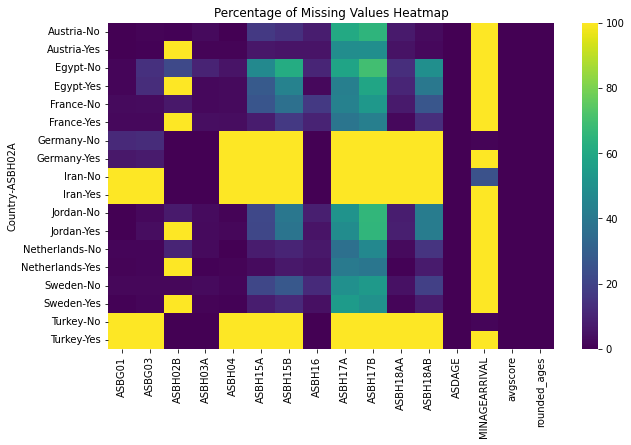

In [6]:
# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_missing, annot=False, cmap='viridis', fmt='.2f')

plt.title('Percentage of Missing Values Heatmap')
plt.show()

I also need to remove values that are '6', meaning nan.

In [7]:
df_demo['ASBH15A'].value_counts()

4.0     7199
7.0     3747
8.0     3086
6.0     2898
3.0     1883
5.0     1285
1.0     1009
2.0      959
9.0      727
10.0     212
Name: ASBH15A, dtype: int64

10 is not applicable - remove?

In [8]:
df_demo['ASBH15B'].value_counts()

4.0     6447
7.0     3019
8.0     2614
6.0     2570
3.0     1725
5.0     1163
1.0     1025
2.0      846
9.0      619
10.0     235
Name: ASBH15B, dtype: int64

hope for level of education - child

In [9]:
df_demo['ASBH16'].value_counts()

6.0    16120
5.0    10986
4.0     4586
2.0     4469
3.0     2411
1.0     1071
9.0      242
Name: ASBH16, dtype: int64

Let's drop all the values that have 9s - omitted. I'm not sure if this is really what I want to do but let's see. 

In [10]:
df_demo.shape 

(41365, 18)

In [11]:
# Columns to check
columns_to_check = ['ASBH02A','ASBH02B','ASBH03A','ASBH04','ASBH16','ASBH18AA','ASBH18AB']

# Drop rows where any of the specified columns have a value of 9.0
condition = (df_demo[columns_to_check] != 9.0).all(axis=1)
df_cleaned = df_demo.loc[condition]
df_cleaned.shape

(40810, 18)

In [12]:
# Columns to check
columns_to_check2 = ['ASBH15A','ASBH15B','ASBH17A','ASBH17B']

# Drop rows where any of the specified columns have a value of 999.0
condition = (df_cleaned[columns_to_check2] != 999.0).all(axis=1)
df_cleaned2 = df_cleaned.loc[condition]
df_cleaned2.shape

(40810, 18)

let's look at the columns that all countries have answers for - 02B - age when arrived in country and 3a speaking lang of test before school? check this!

I need to do some more cleaning if I'm getting results like this! Should not have yesses, and I guess I didn't change all results to ordinal....

Again I want to put the yesses on top of the nos. And do I want to arange the order?

Let's do a pivot adding the lang of test column to the index. 

## Minimum age of arrival

Now I want to see how age of arrival affects average score. I need to first clean the minagearrival column - adding 'NA' for those who were born in country

In [14]:
df_cleaned2['MINAGEARRIVAL'].value_counts(dropna=False)

NaN    40349
0.0      162
3.0      143
6.0      102
8.0       54
Name: MINAGEARRIVAL, dtype: int64

In [15]:
df_cleaned2['ASBH02B'].value_counts(dropna = False)

NaN                         25233
6                           12935
Younger than 3 years old      928
3 to 5 years old              692
6 to 7 years old              375
8 years old or older          186
1                             162
2                             143
3                             102
4                              54
Name: ASBH02B, dtype: int64

In [16]:
df_cleaned2['MINAGEARRIVAL'] = df_cleaned2['MINAGEARRIVAL'].fillna('NA')

In [17]:
df_cleaned2['MINAGEARRIVAL'].value_counts(dropna=False)

NA     40349
0.0      162
3.0      143
6.0      102
8.0       54
Name: MINAGEARRIVAL, dtype: int64

In [18]:
def populate_column(row):
    if row ['ASBH02B'] == 6:
        return 'NA'
    elif row['ASBH02B'] == 'Younger than 3 years old':
        return 0
    elif row['ASBH02B'] == '3 to 5 years old':
        return 3
    elif row['ASBH02B'] == '6 to 7 years old':
        return 6
    elif row['ASBH02B'] == '8 years old or older':
        return 8
    else:
        return row['MINAGEARRIVAL']  

# Apply the function to each row
df_cleaned2['MINAGEARRIVAL'] = df_cleaned2.apply(populate_column, axis=1)

In [19]:
df_cleaned2['MINAGEARRIVAL'].value_counts()

NA     38168
0.0     1090
3.0      835
6.0      477
8.0      240
Name: MINAGEARRIVAL, dtype: int64

In [20]:
df_cleaned2.to_excel('dfdemocleaned.xlsx')